<a href="https://colab.research.google.com/github/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/GANMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np

In [2]:
def get_dl(batchsize):

    # to transform the data as Tensors
    train_transforms = transforms.Compose([transforms.ToTensor()])

    # downloading train and test MNIST Data and transforming it to tensors
    train_data = MNIST(root="./train.",train=True,download=True,transform=train_transforms)
    test_data = MNIST(root="./test.",train=True,download=True,transform=train_transforms)

    # loading the data
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=False,drop_last=True)
    test_loader = DataLoader(test_data,batch_size=batchsize,shuffle=False,drop_last=True)

    # returning the train and test data
    return train_loader,test_loader

In [3]:
class Generator(nn.Module):
    def __init__(self,batch_size,input_dim):
        super().__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim,128)
        self.LRelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128,1*28*28)
        self.tanH = nn.Tanh()

    # function for forward propogation
    def forward(self,x):
        layer1 = self.LRelu(self.fc1(x))
        layer2 = self.tanH(self.fc2(layer1))
        out =layer2.view(self.batch_size,1,28,28)
        return out


In [4]:
class Discriminator(nn.Module):
    def __init__(self,batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.fc1 = nn.Linear(1*28*28,128)
        self.LReLu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128,1)
        self.SigmoidL = nn.Sigmoid()

    # function for forward propogation
    def forward(self,x):
        flat = x.view(self.batch_size,-1)
        layer1 = self.LReLu(self.fc1(flat))
        out = self.SigmoidL(self.fc2(layer1))
        return out.view(-1,1).squeeze(1)

In [5]:
def train_model(no_of_epochs,disc,gen,optimD,optimG,dataloaders,loss_fn,input_size,batch_size):
    """
    disc: Discriminator model
    gen: Generator model
    optimD: Optimizer for Discriminator
    optimG: Optimizer for Generator
    """

    # setting the device as cuda or cpu
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    reall = 1  # real label
    fakel = 0  # fake label
    #running each epoch
    for epoch in range(no_of_epochs):
        print('Epoch {}/{}'.format(epoch+1,no_of_epochs))
        running_loss_D = 0
        running_loss_G = 0
        for phase in ["train"]:
            #getting input and label from dataloader
            for inputs, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                #converting labels into torch with proper size as per the batch size
                real_label = torch.full((batch_size,),reall,dtype=inputs.dtype,device=device)
                fake_label = torch.full((batch_size,),fakel,dtype=inputs.dtype,device=device)

                optimD.zero_grad()
                #output from discriminator
                output =disc(inputs)
                #Discriminator real loss
                # Compairing output label with real label which is loss
                D_real_loss = loss_fn(output,real_label)
                D_real_loss.backward()

                #random torch tensor as a noise data
                noise = torch.randn(batch_size,input_size,device=device)
                #passing noise throgh generator to get fake image
                fake = gen(noise)
                #passing fake image through discriminator with detaching(not passing gradient)
                output = disc(fake.detach())

                #Discriminator fake loss
                D_fake_loss = loss_fn(output,fake_label)
                #back propogation
                D_fake_loss.backward()

                # total loss for Discriminator
                Disc_loss = D_real_loss+D_fake_loss
                running_loss_D = running_loss_D+Disc_loss
                optimD.step()

                optimG.zero_grad()
                #passing fake image obtained from generator to discriminator
                output = disc(fake)
                #getting generator loss by giving fake image as input but giving real label
                Gen_loss = loss_fn(output,real_label)
                running_loss_G = running_loss_G + Gen_loss
                #backpropogation
                Gen_loss.backward()
                optimG.step()
        print("Discriminator Loss : {}".format(running_loss_D))
        print("Generator Loss : {}".format(running_loss_G))

In [6]:
#fixing seed
torch.manual_seed(4)
batch_size = 128
no_of_epochs = 5
#input sixe for the latent variable
input_size = 100
#getting train and test data loader and putting them inside the dictionary
train_loader,test_loader = get_dl(batch_size)
dl = {}
dl['train'] = train_loader
dl['valid'] = test_loader
#discriminator model
disc  = Discriminator(batch_size)
#generator model
gen = Generator(batch_size,input_size)
#Optimizer for Discriminator
optimD  = torch.optim.Adam(disc.parameters(),lr=0.001,weight_decay=1e-05)
#Optimizer for Generator
optimG  = torch.optim.Adam(gen.parameters(),lr=0.001,weight_decay=1e-05)
#Binary cross entroy as loss function
loss_fn = torch.nn.BCELoss()
#moving models to the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
disc.to(device)
gen.to(device)
#training the model
train_model(no_of_epochs,disc,gen,optimD,optimG,dl,loss_fn,input_size,batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 109059055.47it/s]


Extracting ./train./MNIST/raw/train-images-idx3-ubyte.gz to ./train./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36106019.02it/s]


Extracting ./train./MNIST/raw/train-labels-idx1-ubyte.gz to ./train./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28893142.14it/s]


Extracting ./train./MNIST/raw/t10k-images-idx3-ubyte.gz to ./train./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12691891.25it/s]

Extracting ./train./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train./MNIST/raw



100%|██████████| 9912422/9912422 [00:01<00:00, 5684270.75it/s]


Extracting ./test./MNIST/raw/train-images-idx3-ubyte.gz to ./test./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18722672.92it/s]

Extracting ./test./MNIST/raw/train-labels-idx1-ubyte.gz to ./test./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28197858.61it/s]


Extracting ./test./MNIST/raw/t10k-images-idx3-ubyte.gz to ./test./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13378180.31it/s]


Extracting ./test./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test./MNIST/raw

Epoch 1/5
Discriminator Loss : 428.8399353027344
Generator Loss : 752.062255859375
Epoch 2/5
Discriminator Loss : 667.76171875
Generator Loss : 519.8399658203125
Epoch 3/5
Discriminator Loss : 662.0596923828125
Generator Loss : 413.36297607421875
Epoch 4/5
Discriminator Loss : 593.1331176757812
Generator Loss : 427.6587219238281
Epoch 5/5
Discriminator Loss : 597.1973266601562
Generator Loss : 450.6230163574219


In [7]:
import matplotlib.pyplot as plt
#function to plot the image
def show_image(img):
  #converting imgae from tensor to numpy
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

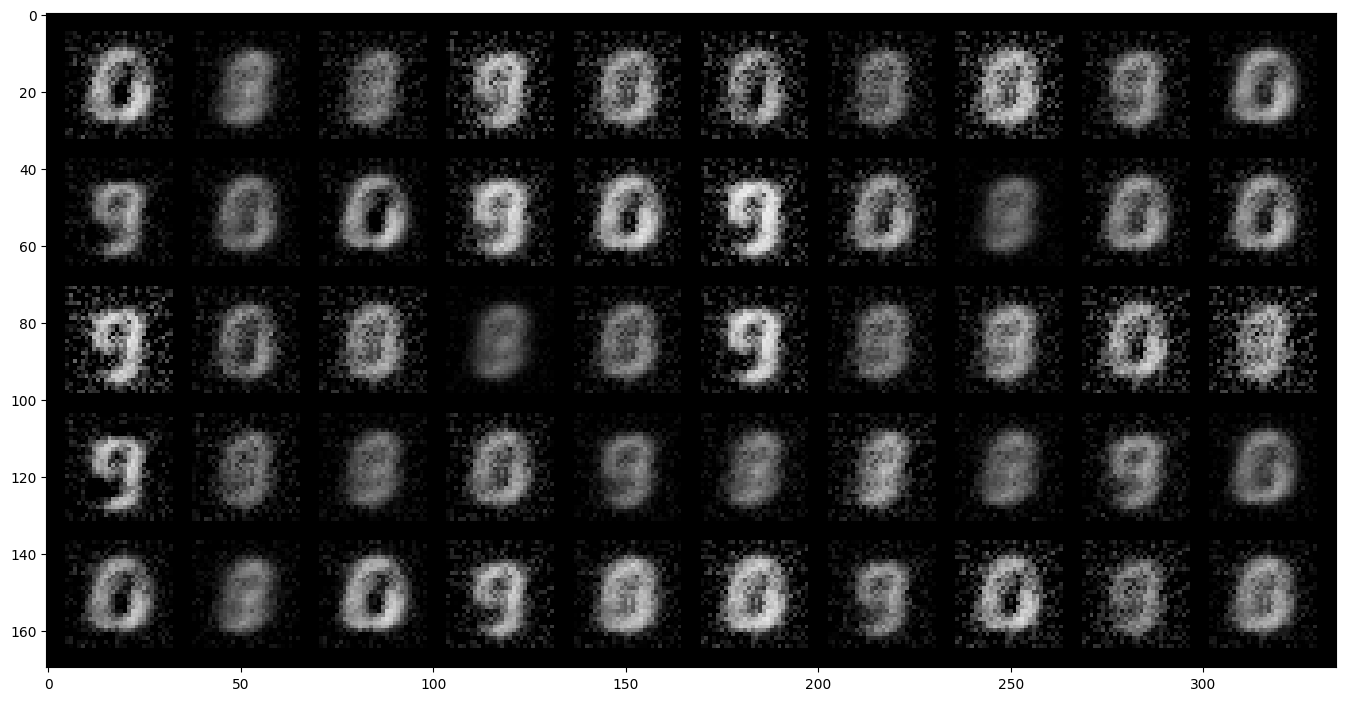

In [8]:
import torchvision
random_noise = torch.randn(128,input_size,device=device)
#generationg fake image from random noise
fake = gen(random_noise)
fake = fake.cpu()
#plotting the fake image
fig,ax = plt.subplots(figsize=(20,8.5))
show_image(torchvision.utils.make_grid(fake[0:50],10,5))
plt.show()